In [ ]:
# default_exp core

In [ ]:
%load_ext autoreload
%autoreload 2

# Core
> Core of this library: DataChunk, RecordMaster, Data_Pipe, and import/export of reM

In [ ]:
from nbdev.showdoc import *

In [ ]:
#export
import h5py
import json
import numpy as np
from collections import namedtuple 
from typing import Dict, Tuple, Sequence, Union
import itertools
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

class DataChunk(np.ndarray):
    """Base brick of data."""
    def __new__(cls, data, idx, group, fill=0):
        # See https://docs.scipy.org/doc/numpy-1.11.0/user/basics.subclassing.html#basics-subclassing
        # for explanation on subclassing numpy arrays
        obj = np.asarray(data).view(cls)
        obj.idx = idx
        obj.group = group
        obj.fill = fill
        
        obj.attrs = {}
        
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        self.idx   = getattr(obj, 'idx', None)
        self.group = getattr(obj, 'group', None)
        self.fill  = getattr(obj, 'fill', 0)
        self.attrs = getattr(obj, 'attrs', {})
        

    @property
    def range(self):
        return range(self.idx, self.idx + len(self))
    
    @property
    def slice(self):
        return slice(self.idx, self.idx + len(self))

    def __str__(self):
        return ("Group: "+str(self.group)
                +"\nStarting index: "+str(self.idx)
                +"\nFilling value: "+str(self.fill)
                +"\n"+super().__str__())
    
    def __repr__(self):
        return "DataChunk(%s,%s,%s,%s)"%(self.shape, self.idx, self.group, self.fill)

In [ ]:
#export
class ContiguousRecord():
    """Representation of a contiguous recording session to store DataChunk
    of various sources under a single time reference. DataChunk are stored
    under a name in one of the groups "sync","stim","data" and "cell". 
    
    A name can contain multiple DataChunk if those are not overlapping in time.
    
    Each ContiguousRecord contains in the group "sync" two master DataChunk,
    one for signals to be recorded across acquisition device to syncronize them,
    one for timepoints of these signals for the main device and are called 
    respectively "signals" and "main_tp".
    
    """
    MAIN_TP = "main_tp"
    SIGNALS = "signals"
    def __init__(self, length:int, signals:DataChunk, main_tp:DataChunk):
        """Instanciate a ContiguousRecord.
        
        Parameters:
            length (int): Number of bins of this record
            signals (DataChunk): Signals for this record
            main_tp (DataChunk): Timepoints of the signals for the main device
        """
        self.length = length
        self._data_dict = {}  
        
        self[self.SIGNALS] = signals
        self[self.MAIN_TP] = main_tp
        
        self._slice = slice(0,self.length,1)
      
    def dataset_intersect(self, existing_datachunk:list, new_datachunk:DataChunk):
        range_new = set(new_datachunk.range)
        intersect = False
        for range_existing in existing_datachunk:
            intersect |= len(range_new.intersection(range_existing.range)) > 0
        return intersect
    
    def keys(self):
        return self._data_dict.keys()
    
    def get_slice(self, datachunk_name:str) -> list:
        if datachunk_name in self._data_dict.keys():
            return [chunk.slice for chunk in self._data_dict[datachunk_name]]
        else:
            return []
        
    def set_slice(self, slice_):
        """Set the slice to restrict the size of the DataChunk returned"""
        if slice_ is None:
            self._slice = slice(0,self.length,1)
        else:
            start, stop, step = slice_.start, slice_.stop, slice_.step
            if start is None:
                start = 0
            if stop is None:
                stop = self.length
            if step is None:
                step = 1
            if step!=1:
                print("Step in slice is currently not supported.")
                self._slice = slice(0,self.length,1)
            else:
                self._slice = slice(start,stop,step)
                    
    
    def get_names_group(self, group_name:str) -> list:
        names = []
        for key, dChunk_l in self._data_dict.items():
            if dChunk_l[0].group == group_name:
                names.append(key)
        return names
        
    def __len__(self):
        return self.length
    
    def __setitem__(self, key, value:DataChunk):
        if isinstance(key, str):
            if key not in self._data_dict.keys():
                self._data_dict[key] = []
                
            if not self.dataset_intersect(self._data_dict[key], value):
                self._data_dict[key].append(value)
            else:
                raise ValueError("Data with the same name already exists and intersect with the one provided")
        else:
            raise KeyError("Cannot set data with an integer index, it needs a name")

    def __getitem__(self, key):
        if isinstance(key, str):
            l_datachunk = self._data_dict[key]
            fill_value  = l_datachunk[0].fill
            shape       = l_datachunk[0].shape
            
            full_sequence = DataChunk(np.zeros((len(range(*self._slice.indices(self.length))), *shape[1:]), 
                                               dtype=l_datachunk[0].dtype)+fill_value, 
                                      self._slice.start if self._slice.start is not None else 0, 
                                      fill_value)
            for datachunk in l_datachunk:
                dc_slice = datachunk.slice
                if dc_slice.start>=self._slice.stop or dc_slice.stop<=self._slice.start:
                    continue
                
                start = max(dc_slice.start, self._slice.start) #flooring to the maximum of both start
                stop  = min(dc_slice.stop, self._slice.stop) # and capping to the min of both end
                    
                new_dc_slice  = slice(start-datachunk.idx, stop-datachunk.idx)
                res_start = self._slice.start if self._slice.start is not None else 0
                res_slice = slice(start-res_start, stop-res_start)
                full_sequence[res_slice] = datachunk.data[new_dc_slice]
                full_sequence.attrs.update(datachunk.attrs)
            
            return full_sequence
                
    def __iter__(self):             
        groups = {"sync":[],"stim":[],"data":[],"cell":[]}
        for key, dChunk_l in self._data_dict.items():
            groups[dChunk_l[0].group].append((dChunk_l[0].idx, key))

        self._iter_order = []
        for group_name in ["sync","stim","data","cell"]:
            sorted_ = sorted(groups[group_name], key=lambda e:(e[0],))
            self._iter_order.extend([key for _, key in sorted_])
        self._n = 0
        
        return self

    def __next__(self):
        if self._n < len(self._iter_order):
            key = self._iter_order[self._n]
            dChunk_l = self._data_dict[key]
            self._n += 1
            return (key, dChunk_l)
        else:
            raise StopIteration
            
    def __delitem__(self, key):
        del self._data_dict[key]
        
    def __str__(self):
        res = "ContiguousRecord:\n"
        for k,v in self._data_dict.items():
            res += k+" : "+" ".join([str(dc.shape) for dc in v]) +"\n"
        return res
    
    def __repr__(self):
        return self._data_dict.__repr__()

In [ ]:
#export
class RecordMaster(list):
    """
    One Timeserie to rule them all, One Timeserie to find them,
    One Timeserie to bring them all and in the darkness bind them
    
    The RecordMaster class is the top level object managing all
    timeseries. It uses a list of ContiguousRecord to represent
    possible discontinuted data records.
    
    The main aim of the RecordMaster is to store the various data
    stream of an experiment under a unique time reference, to ease
    the processing of the data.
    """
    
    def __init__(self, reference_data_list: Sequence[Tuple[DataChunk, DataChunk]], frame_time=1/60, sep_size=1000):
        
        self.frame_time = frame_time
        self.sep_size   = sep_size
        self._sequences = []
        for ref_timepoints, ref_signals in reference_data_list:
            cs = ContiguousRecord(len(ref_timepoints), ref_signals, ref_timepoints)
            self._sequences.append(cs)
            
    def set_datachunk(self, dc:DataChunk, name:str, sequence_idx=0):
        """Set the given DataChunk dc for the sequence at sequence_idx under name."""
        self._sequences[sequence_idx][name] = dc
        
    def append(self, ref_timepoints:DataChunk, ref_signals:DataChunk):
        cs = ContiguousRecord(len(ref_timepoints), ref_signals, ref_timepoints)
        self._sequences.append(cs)
        
    def insert(self, idx:int, ref_timepoints:DataChunk, ref_signals:DataChunk):
        cs = ContiguousRecord(len(ref_timepoints), ref_signals, ref_timepoints)
        self._sequences.insert(idx, cs)
        
    def __setitem__(self, key, value:DataChunk):
        """Setting an item directly to the record_master place it in the first sequence"""
        if isinstance(key, str):
            self._sequences[0][key] = value
        
    def __getitem__(self, key):
        if isinstance(key, (int, np.integer)):
            return self._sequences[key]
        elif isinstance(key, str):
            #We want all the data of that name
            res = []
            for seq in self._sequences:
                res.append(seq[key])
            return res

        raise TypeError("Indexing not understood")
        
    def __iter__(self):
        self._n = 0
        return self
    
    def __next__(self):
        if self._n < len(self):
            res = self._sequences[self._n]
            self._n += 1
            return res
        else:
            raise StopIteration 
            
    def __len__(self):
        return len(self._sequences)
        
    def plot(self, ax=None):
        colors = {"sync":"cornflowerblue", "stim":"orange", "data":"yellowgreen", "cell":"plum"}
        cursor = 0
        y_pos_dict = {}
        y_count    = 0
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))
        ax.invert_yaxis()
        ax.xaxis.set_visible(False)
        for seq in self._sequences:
            for y, (name, dChunk_l) in enumerate(seq):
                for dChunk in dChunk_l:
                    pos = dChunk.idx + cursor 
                    ax.barh(name, len(dChunk), left=pos, height=0.8, color=colors[dChunk.group], label=dChunk.group)
                    x = pos + len(dChunk)/2
                    text = "{0} -> {1} ".format(self.to_time_str(dChunk.idx), self.to_time_str(dChunk.idx+len(dChunk)))
                    if name not in y_pos_dict.keys():
                        y_pos_dict[name] = y_count
                        y_count+=1
                    y_pos = y_pos_dict[name]
                    ax.text(x, y_pos, text, ha='center', va='center')
            cursor += len(seq) + self.sep_size
            
        legend_elements = [Patch(facecolor=colors["sync"],label='Synchro'),
                           Patch(facecolor=colors["data"],label='Data'),
                           Patch(facecolor=colors["stim"],label='Stimulus'),
                           Patch(facecolor=colors["cell"],label='Cell'),]
        ax.legend(handles=legend_elements, ncol=5, bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
        
        ax.set_xlim(-100,cursor)
            
    def to_s(self, n_frame):
        return round(self.frame_time*n_frame,2)
    
    def to_time_str(self, n_frame):
        s = int(self.to_s(n_frame))
        m, s = s//60, str(s%60)
        h, m = str(m//60), str(m%60)
        return "{0}:{1}:{2}".format('0'*(2-len(h))+h, '0'*(2-len(m))+m, '0'*(2-len(s))+s)
    
    def __str__(self):
        return "["+",\n".join([repr(seq) for seq in self._sequences])+"]"
    
    def __repr__(self):
        return "["+", ".join([repr(seq) for seq in self._sequences])+"]"

In [ ]:
#export
class Data_Pipe():
    def __init__(self, record_master:RecordMaster, data_names:Union[str,list], target_names:Union[str,list]=None):
        self.record_master = record_master
        if isinstance(data_names, str):
            data_names = [data_names]
        
        if isinstance(target_names, str):
            target_names = [target_names]
            
        if target_names is None:
            target_names = data_names
        elif len(data_names) != len(target_names):
            raise Exception("data_names and target_names length must match")
        
        self.target_names = target_names
        self.data_names = data_names
        self._masks     = [np.zeros(len(seq), dtype=bool) for seq in record_master]
        self._slices    = []
        
    def plot(self, newfig=False):
        factor = -1
        if newfig:
            plt.figure()
            factor = 1
        cursor = 0
        for i,seq in enumerate(self.record_master):
            plt.plot(range(cursor,cursor+len(seq)), self._masks[i]*factor-1)
            cursor += len(seq) + self.record_master.sep_size
            
    def copy(self):
        new_pipe =  Data_Pipe(record_master=self.record_master, 
                         data_names=self.data_names,
                         target_names=self.target_names)
        new_pipe._masks = np.copy(self._masks)
        new_pipe._slices = self._slices.copy()
        return new_pipe
        
    def _get_dchunk_names(self, names):
        if isinstance(names, str):
            names = [names]
        dchunk_name = []
        for seq in self.record_master:
            for name in names:
                if name in ["sync", "cell", "data", "stim"]:
                    dchunk_name.extend(seq.get_names_group(name))
                else:
                    dchunk_name.append(name)
        return list(set(dchunk_name))
    
    def _intersect_names(self):        
        for i, seq in enumerate(self.record_master):
            for name in self.data_names:
                if name not in seq.keys():
                    self._masks[i] = np.zeros(len(seq), dtype=bool)
                    break
            
    def _update_slices(self):
        self._intersect_names() #Always intersect the names we wanna retrieve 
        self._slices = []
        #Iterating the list of mask (one per seq of the record_master)
        for j, mask in enumerate(self._masks):
            seq = self.record_master[j]
            mask = np.concatenate(([0],mask,[0])) #Putting zeros on the side in case the limits would be ones
            for start, stop in np.where(mask[1:]-mask[:-1])[0].reshape(-1,2):#Split the mask where 0 separates the 1
                self._slices.append((j, slice(start,stop)))
        
    def __ior__(self, names:Union[str, list]):
        return self.__iadd__(names)
    def __or__(self, names:Union[str, list]):
        return self.copy().__ior__(names)
    
    def __iand__(self, names:Union[str, list]):
        dchunk_name = self._get_dchunk_names(names)
        for i, seq in enumerate(self.record_master):
            new_mask = np.zeros(len(seq), dtype=bool)
            for name in dchunk_name:
                for slice_ in seq.get_slice(name):
                    new_mask[slice_] = 1
            self._masks[i] &= new_mask                
        self._update_slices()
        return self
    def __and__(self, names:Union[str, list]):
        return self.copy().__iand__(names)
    
    def __ixor__(self, names:Union[str, list]):
        dchunk_name = self._get_dchunk_names(names)
        for i, seq in enumerate(self.record_master):
            new_mask = np.zeros(len(seq), dtype=bool)
            for name in dchunk_name:
                for slice_ in seq.get_slice(name):
                    new_mask[slice_] = 1
            self._masks[i] ^= new_mask
        self._update_slices()
        return self
    def __xor__(self, names:Union[str, list]):
        return self.copy().__ixor__(names)
        
    def __iadd__(self, names:Union[str, list]):
        dchunk_name = self._get_dchunk_names(names)
        for i, seq in enumerate(self.record_master):
            for name in dchunk_name:
                for slice_ in seq.get_slice(name):
                    self._masks[i][slice_] = 1
        self._update_slices()
        return self
    def __add__(self, names:Union[str, list]):
        return self.copy().__iadd__(names)
    
    def __isub__(self, names:Union[str, list]):
        dchunk_name = self._get_dchunk_names(names)
        for i, seq in enumerate(self.record_master):
            for name in dchunk_name:
                for slice_ in seq.get_slice(name):
                    self._masks[i][slice_] = 0
        self._update_slices()
        return self
    def __sub__(self, names:Union[str, list]):
        return self.copy().__isub__(names)
                
    def __iter__(self):
        self._n = 0
        return self
    
    def __next__(self):
        if self._n < len(self):
            res = {}
            seq_idx, _slice = self._slices[self._n]
            self.record_master[seq_idx].set_slice(_slice)
            for i, name in enumerate(self.data_names):
                res[self.target_names[i]] = self.record_master[seq_idx][name]#[_slice]
            self.record_master[seq_idx].set_slice(None)
            self._n += 1
            return res
        else:
            raise StopIteration 
    
    def __len__(self):
        return len(self._slices)
            
    def __getitem__(self, key):
        if isinstance(key, (int, np.integer)):
            seq_idx, _slice = self._slices[key]
            self.record_master[seq_idx].set_slice(_slice)
            res = {}
            for i, name in enumerate(self.data_names):
                res[self.target_names[i]] = self.record_master[seq_idx][name]#[_slice]
            self.record_master[seq_idx].set_slice(None)
            return res
        elif isinstance(key, slice):
            l_res = []
            for seq_idx, _slice in self._slices[key]:
                res = {}
                for i, name in enumerate(self.data_names):
                    res[self.target_names[i]] = self.record_master[seq_idx][name][_slice]
                l_res.append(res)
            return l_res
        else:
            raise IndexError ("only integers and slices (`:`) are valid indices")
      
    def __str__(self):
        return "(datachunks, targets, slices), "+self.__repr__()
    
    def __repr__(self):
        return "Pipe(%s)"%(repr(self.data_names)+", "+repr(self.target_names)+", "+repr(self._slices))

In [ ]:
#Some testing of the lib
from nbdev.test import test_eq
from collections import namedtuple
import numpy as np

#Load all the test data
from theonerig.testdata import *
locals().update(load_vivo_2p("./files/vivo_2p"))

#Few tests on the shape of the data
test_eq(S_matrix.shape, (2, 49000))
test_eq(np.sum(len_records), S_matrix.shape[1])
test_eq(eye_TP.shape[0], eye_DATA.shape[0])
test_eq(proj_TP.shape, proj_DATA.shape)

Importing the record master

Returning stim_d, S_matrix, A_matrix, proj_TP, proj_DATA, eye_TP, eye_DATA, treadm_DATA, len_records, rec_TP, reM


In [ ]:
from theonerig.utils import *

#Extending the main timepoints to left and right to cover the whole duration of the record
timepoints_chunkD, signals_chunkD = extend_sync_timepoints(proj_TP, proj_DATA, up_bound=proj_TP[-1]+100000)
reM = RecordMaster([(timepoints_chunkD, signals_chunkD)])

#Downsample the treadmill acquired at 10kHz to 60Hz.
treadm_chunkD = resample_to_timepoints(list(range(len(treadm_DATA))),treadm_DATA, timepoints_chunkD)
reM.set_datachunk(dc=treadm_chunkD, name="treadmill")

#Upsample the eye tracking acquired at 15Hz to 60Hz.
eye_upsamp = resample_to_timepoints(eye_TP, eye_DATA, timepoints_chunkD)
reM.set_datachunk(dc=eye_upsamp, name="eye_tracking")

#Iterating over the record lengths to create all datachunk
cursor = 0
for i, len_record in enumerate(len_records):
    resampled_dataChunk = resample_to_timepoints(timepoints = rec_TP[i][0:len_record],
                           data = S_matrix.T[cursor:cursor+len_record],
                           ref_timepoints = timepoints_chunkD,
                           group="cell")
    cursor += len_record
    reM.set_datachunk(dc=resampled_dataChunk, name="S_matrix")

for stim_key in stim_d.keys():
    idx = stim_key.split("_")[0]
    name = "_".join(stim_key.split("_")[1:])
    #Stim data are in the timing of the main sync, no need for resampling
    reM[name] = DataChunk(data=stim_d[stim_key], idx=int(idx) ,group="stim")

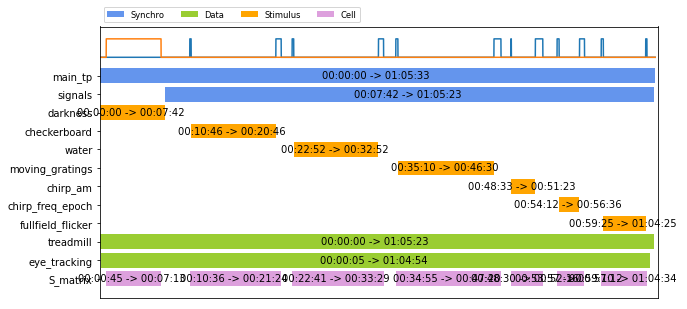

In [ ]:
pipe_1 = Data_Pipe(reM, data_names=["S_matrix", "treadmill"], target_names=["spike_counts", "treadmill"])
pipe_1 += "S_matrix" #We can +,-,&,| symbols to add masks to the pipe
pipe_1 -= "stim"     #Name of a group can be use instead of individual DataChunk

pipe_2 = Data_Pipe(reM, data_names=["S_matrix", "treadmill"], target_names=["spike_counts", "treadmill"])
pipe_2 += "darkness" #We can +,-,&,| symbols to add masks to the pipe
pipe_2 &= "S_matrix"     #Name of a group can be use instead of individual DataChunk

reM.plot()
pipe_1.plot() #Plotting the pipe after plotting its recordMaster reference will add it to the plot
pipe_2.plot() #pipe_1 and pipe_2 appear respectively blue and orange on the plot

In [ ]:
#Pipe can be iterated, or indexed to get the dictionnary of the epochs seen by masking
test_eq(len(pipe_1), 12)
test_eq(len(pipe_2), 1)
test_eq(list(pipe_1[0].keys()), ["spike_counts", "treadmill"])
test_eq(list(pipe_2[0].keys()), ["spike_counts", "treadmill"])

print("Pipe 1 shapes")
print(" ".join([str(data_d["spike_counts"].shape) for data_d in pipe_1]))
print("Pipe 2 shapes")
print(" ".join([str(data_d["spike_counts"].shape) for data_d in pipe_2]))

Pipe 1 shapes
(579, 2) (2270, 2) (681, 2) (2174, 2) (900, 2) (2987, 2) (219, 2) (3177, 2) (863, 2) (2109, 2) (893, 2) (532, 2)
Pipe 2 shapes
(23303, 2)


In [ ]:
#export
def export_record(_path, record_master):
    """Export a Record_Master object to an h5 file, readable outside of this library."""
    print("Exporting the record master")
    with h5py.File(_path, mode="w") as h5_f:
        h5_f.attrs["frame_time"] = record_master.frame_time
        h5_f.attrs["sep_size"]   = record_master.sep_size
        for i, contig in enumerate(record_master):
            #create contig
            print("Contiguous sequence",i)
            cntig_ref = h5_f.create_group(str(i))
            cntig_ref.attrs["length"] = contig.length
            for key, dc_list in contig._data_dict.items():
                #create datastream
                print("...Entering stream",key)
                stream_ref = cntig_ref.create_group(key)
                for datachunk in dc_list:
                    print("......",str(datachunk.idx)+"->"+str(datachunk.idx+len(datachunk)))
                    dset = stream_ref.create_dataset(str(datachunk.idx), data=np.array(datachunk), compression="gzip", compression_opts=4)
                    for attr_k, attr_v in datachunk.attrs.items():
                        dset.attrs[attr_k] = json.dumps(attr_v)
                    dset.attrs["__fill"] = datachunk.fill
                    dset.attrs["__group"] = datachunk.group
    print()
                    
def import_record(_path):
    """Import a Record_Master from an h5 file saved by the export_record function of this library."""
    print("Importing the record master")
    with h5py.File(_path, mode="r") as h5_f:
        record_master = None
        for j, key_contig in enumerate(h5_f.keys()):
            ref_contig = h5_f[key_contig]
            stream_d = {}
            for i, key_dstream in enumerate(ref_contig.keys()): 
                ref_dstream = ref_contig[key_dstream]
                dchunk_l = []
                for key_dc in ref_dstream.keys():
                    
                    data = ref_dstream[key_dc]
                    idx  = int(key_dc)
                    attrs = {}
                    for k,v in data.attrs.items():
                        if k not in  ["__fill", "__group"]:
                            attrs[k] = json.loads(v)
                        elif k == "__fill":
                            fill = v
                        elif k == "__group":
                            group = v
                    dchunk = DataChunk(data=data[:], idx=idx, group=group)
                    dchunk.attrs = attrs
                    dchunk_l.append(dchunk)
                    
                stream_d[key_dstream] = dchunk_l
            if record_master is None:
                record_master = RecordMaster([(stream_d["main_tp"][0],stream_d["signals"][0])])
            else:
                record_master.append(stream_d["main_tp"][0],stream_d["signals"][0])
            for kstream, vstream in stream_d.items():
                for k, dc in enumerate(vstream):
                    if kstream in ["main_tp", "signals"] and k==0:
                        continue
                    record_master.set_datachunk(dc, name=kstream, sequence_idx=j)
    print()
    return record_master

In [ ]:
from os.path import join
export_record(join(vivo_2p_dir, "record_master.h5"), reM)
reM_loaded = import_record(join(vivo_2p_dir, "record_master.h5"))

Exporting the record master
Contiguous sequence 0
...Entering stream signals
...... 27759->235393
...Entering stream main_tp
...... 0->235994
...Entering stream treadmill
...... 1->235393
...Entering stream eye_tracking
...... 331->233657
...Entering stream S_matrix
...... 2703->26006
...... 38207->77056
...... 81695->120550
...... 125746->170433
...... 174618->188214
...... 194273->205925
...... 213032->232457
...Entering stream darkness
...... 0->27759
...Entering stream checkerboard
...... 38786->74786
...Entering stream water
...... 82376->118376
...Entering stream moving_gratings
...... 126646->167446
...Entering stream chirp_am
...... 174837->185037
...Entering stream chirp_freq_epoch
...... 195136->203816
...Entering stream fullfield_flicker
...... 213925->231925

Importing the record master



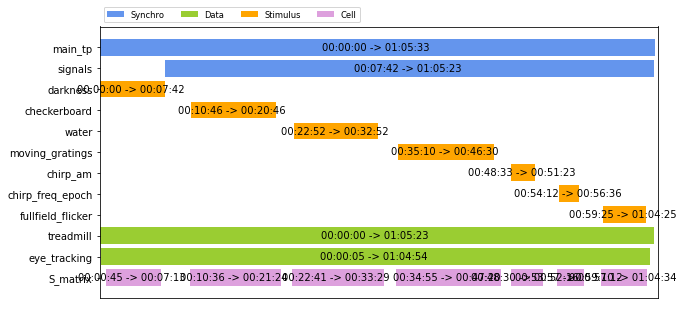

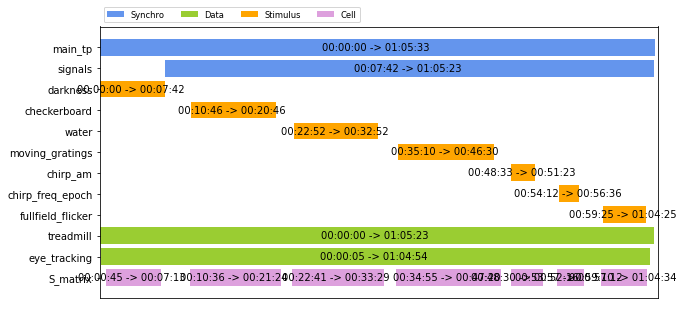

In [ ]:
reM.plot()
reM_loaded.plot()

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_processing.ipynb.
Converted 03_modelling.ipynb.
Converted 04_plotting.ipynb.
Converted 05_database.ipynb.
Converted 10_synchro.io.ipynb.
Converted 11_synchro.extracting.ipynb.
Converted 12_synchro.processing.ipynb.
Converted 99_testdata.ipynb.
Converted index.ipynb.
